In [31]:
!pip install xgboost
!pip install imbalanced-learn

In [32]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [33]:
#load dataframe
b = pd.read_csv('both clean 2.csv')
''' b contains both datasets. no handling null values'''

<ipython-input-33-dc909915fa4d>:2: DtypeWarning: Columns (4,5,7,8,9,13,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  b = pd.read_csv('both clean 2.csv')


' b contains both datasets. no handling null values'

In [34]:
columns_to_fill = ['Phone Area Code', 'Phone Number','Lead Status', 'Lead Quality', 'Lead Source','Campaign Name',
                   'Lead Created Date', 'download_date']

# Fill null values with 'None' in specified columns
b[columns_to_fill] = b[columns_to_fill].fillna('None')

In [35]:
#create the column 'Lead at all' based on the score
b['score'].unique()
b['Lead at all'] = b['score'].apply(lambda x: 1 if x >= -1 else 0 if x < -1 else 'NA')

In [36]:
#Use one hot encoding for categorical variables.
encoded_property_city = pd.get_dummies(b['Property City'], prefix='Property_City')
encoded_property_state = pd.get_dummies(b['Property State'], prefix='Property_State')
encoded_property_zip = pd.get_dummies(b['Property Zip'].astype(str), prefix='Property_Zip')
encoded_mailing_city = pd.get_dummies(b['Mailing City'], prefix='Mailing_City')
encoded_mailing_state = pd.get_dummies(b['Mailing State'], prefix='Mailing_State')
encoded_mailing_zip = pd.get_dummies(b['Mailing Zip'].astype(str), prefix='Mailing_Zip')
encoded_house_type = pd.get_dummies(b['House Type'], prefix='House Type')
encoded_gender = pd.get_dummies(b['Gender'], prefix='Gender')


In [37]:
# Combine all the encoded features into a single DataFrame
b_features = pd.concat([
    encoded_property_city,
    encoded_property_state,
    encoded_property_zip,
    encoded_mailing_city,
    encoded_mailing_state,
    encoded_mailing_zip,
    encoded_gender,
    b['Bedroom'],
    b['Bathroom'],
    b['Apporx Sqft'],
    b['Lot Size Sqft'],
    b['Effective Year Built'],
    b['Tax Assessed Value'],
    b['Last Sold Price'],
], axis=1)

In [38]:
#train split and duplication

X = b_features
y = b['Lead at all']

# Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

# Identify and Separate Minority and Majority Classes
minority_class = y_train.value_counts().idxmin()
majority_class = y_train.value_counts().idxmax()

X_train_minority = X_train[y_train == minority_class]
y_train_minority = y_train[y_train == minority_class]
X_train_majority = X_train[y_train == majority_class]
y_train_majority = y_train[y_train == majority_class]

#  Duplicate Rarer Events to Balance the Dataset
n_minority = len(X_train_minority)
n_majority = len(X_train_majority)
n_duplicate = n_majority - n_minority

X_train_minority_upsampled = X_train_minority.sample(n=n_duplicate, replace=True, random_state=42)
y_train_minority_upsampled = y_train_minority.sample(n=n_duplicate, replace=True, random_state=42)

X_train_balanced = pd.concat([X_train_majority, X_train_minority, X_train_minority_upsampled])
y_train_balanced = pd.concat([y_train_majority, y_train_minority, y_train_minority_upsampled])

In [39]:
'''
model1.
xgboost with RE and raw datas, predicting if will become any sort of lead. Duplicate rarer events to balance data.
test size = .2

XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)


predicters:
'Property City', 'Property State', 'Property Zip', 'Mailing City', 'Mailing State', 'Mailing Zip'
'Bedroom', 'Bathroom', 'Apporx Sqft','Lot Size Sqft', 'Effective Year Built', 'House Type',
'Tax Assessed Value', 'Last Sold Price'

target:
'Lead at all'

F1 Score: 0.3320061255742726
Test Accuracy: 0.9663617995897404
Test Recall: 0.8741935483870967
Test Precision: 0.20491493383742912

'''

"\nmodel1.\nxgboost with RE and raw datas, predicting if will become any sort of lead. Duplicate rarer events to balance data.\ntest size = .2\n\nXGBClassifier(\n    use_label_encoder=False,\n    eval_metric='mlogloss',\n    n_estimators=100,\n    max_depth=4,\n    learning_rate=0.1,\n    subsample=0.8,\n    colsample_bytree=0.8\n)\n\n\npredicters:\n'Property City', 'Property State', 'Property Zip', 'Mailing City', 'Mailing State', 'Mailing Zip'\n'Bedroom', 'Bathroom', 'Apporx Sqft','Lot Size Sqft', 'Effective Year Built', 'House Type',\n'Tax Assessed Value', 'Last Sold Price'\n\ntarget:\n'Lead at all'\n\nF1 Score: 0.7592319054652882\nTest Accuracy: 0.9718892817107873\nTest Recall: 0.8290322580645161\nTest Precision: 0.7002724795640327\n\n"

F1 Score: 0.3320061255742726
Test Accuracy: 0.9663617995897404
Test Recall: 0.8741935483870967
Test Precision: 0.20491493383742912


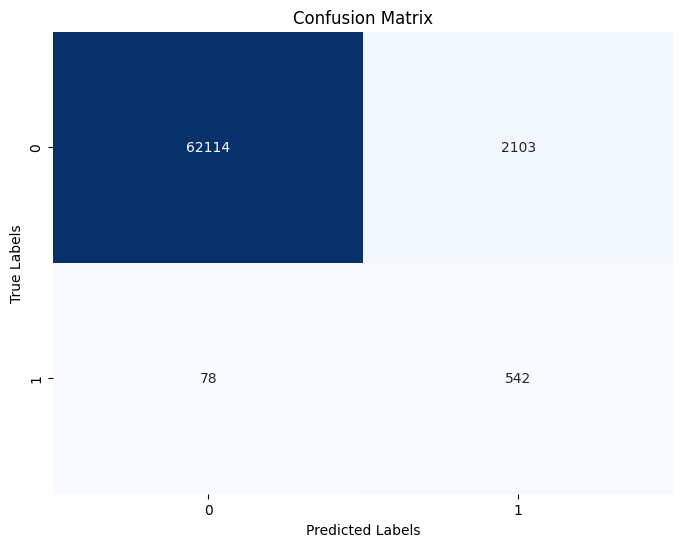

<Figure size 1000x800 with 0 Axes>

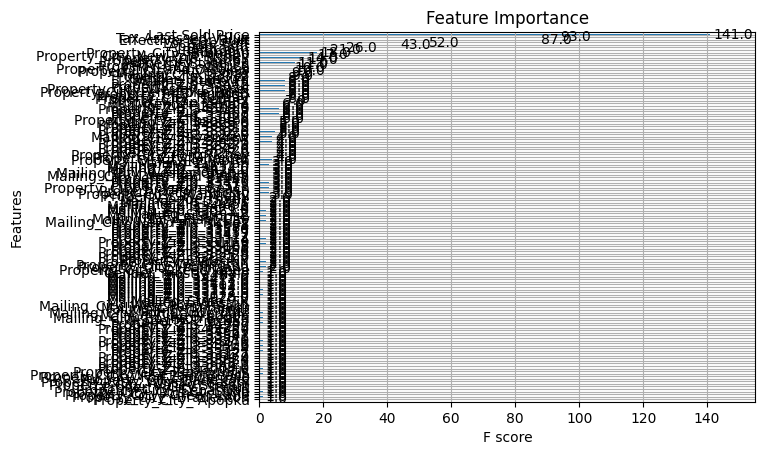

                           Feature  Importance
143                Last Sold Price       141.0
142             Tax Assessed Value        93.0
141           Effective Year Built        87.0
140                  Lot Size Sqft        52.0
139                    Apporx Sqft        43.0
..                             ...         ...
9    Property_City_ Port St. Lucie         1.0
12        Property_City_ Sebastian         1.0
14           Property_City_ Stuart         1.0
128            Mailing_Zip_33487.0         1.0
135             Gender_mostly_male         1.0

[144 rows x 2 columns]
                           Feature  Importance
143                Last Sold Price       141.0
142             Tax Assessed Value        93.0
141           Effective Year Built        87.0
140                  Lot Size Sqft        52.0
139                    Apporx Sqft        43.0
137                        Bedroom        26.0
138                       Bathroom        21.0
2           Property_City_ Brandon  

<ipython-input-40-1d8d4cbff416>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_15_features, palette='viridis')


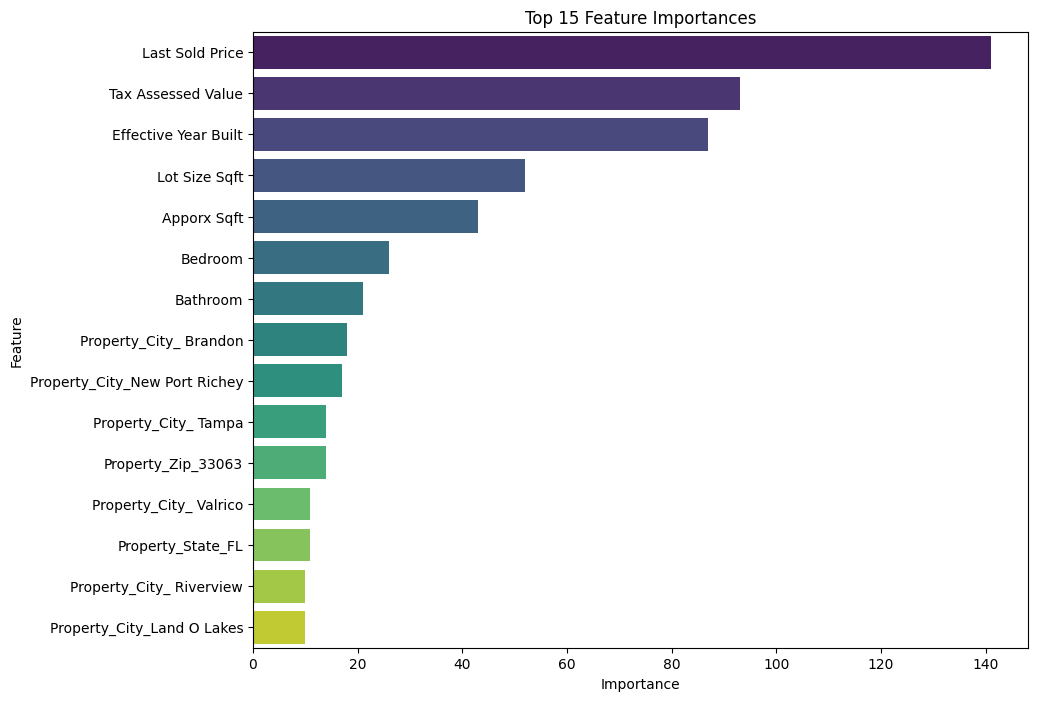

In [40]:
#training model1

#  Manually Set Hyperparameters
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

#  Train the Model
model1 = xgb.fit(X_train_balanced, y_train_balanced)

#  Evaluate the Model
y_pred = model1.predict(X_test)

accuracy1 = accuracy_score(y_test, y_pred)
recall1 = recall_score(y_test, y_pred, average='binary')  # Use average='binary' for binary classification
precision1 = precision_score(y_test, y_pred, average='binary')  # Use average='binary' for binary classification
f1 = f1_score(y_test, y_pred)

print("F1 Score:", f1)
print(f"Test Accuracy: {accuracy1}")
print(f"Test Recall: {recall1}")
print(f"Test Precision: {precision1}")


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=xgb.classes_, yticklabels=xgb.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


  # Plot Feature Importances
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(model1, importance_type='weight')
plt.title('Feature Importance')
plt.show()

#  Get Feature Importances as a DataFrame
feature_importances = model1.get_booster().get_score(importance_type='weight')
feature_importances_df = pd.DataFrame(feature_importances.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
print(feature_importances_df)

# Get top 15 features
top_15_features = feature_importances_df.head(15)
print(top_15_features)

# Plot top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_15_features, palette='viridis')
plt.title('Top 15 Feature Importances')
plt.show()


In [41]:
'''

Model 2.
xgboost with RE and raw datas, predicting if will become any sort of lead.
Duplicate rarer events to balance data. adjusted hyperparameters to adjust for underfitting

xgb1b = XGBClassifier(
    max_depth=6,              # Increase max_depth
    min_child_weight=1,       # Lower min_child_weight
    gamma=0,                  # Lower gamma
    subsample=0.8,            # Increase subsample
    colsample_bytree=0.8,     # Increase colsample_bytree
    learning_rate=0.05,       # Lower learning_rate
    n_estimators=200          # Increase n_estimators
)


F1 Score: 0.44289807613589854
Test Accuracy: 0.9790088992396317
Test Recall: 0.8725806451612903
Test Precision: 0.29676357652221613


test size = .5

'''

'\n\nmodel1b.\nxgboost with RE and raw datas, predicting if will become any sort of lead.\nDuplicate rarer events to balance data. adjusted hyperparameters to adjust for underfitting\n\nxgb1b = XGBClassifier(\n    max_depth=6,              # Increase max_depth\n    min_child_weight=1,       # Lower min_child_weight\n    gamma=0,                  # Lower gamma\n    subsample=0.8,            # Increase subsample\n    colsample_bytree=0.8,     # Increase colsample_bytree\n    learning_rate=0.05,       # Lower learning_rate\n    n_estimators=200          # Increase n_estimators\n)\n\n\nF1 Score: 0.8290076335877863\nTest Accuracy: 0.980684659825817\nTest Recall: 0.8758064516129033\nTest Precision: 0.7869565217391304\n\n\ntest size = .5\n\n'

F1 Score: 0.44289807613589854
Test Accuracy: 0.9790088992396317
Test Recall: 0.8725806451612903
Test Precision: 0.29676357652221613


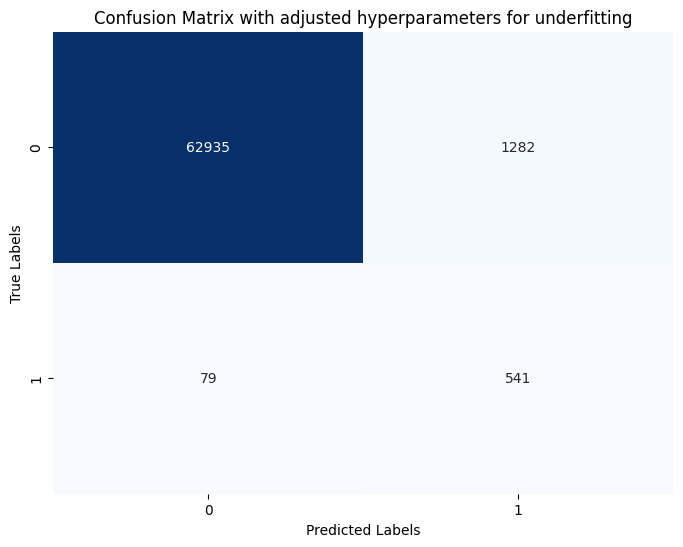

<Figure size 1000x800 with 0 Axes>

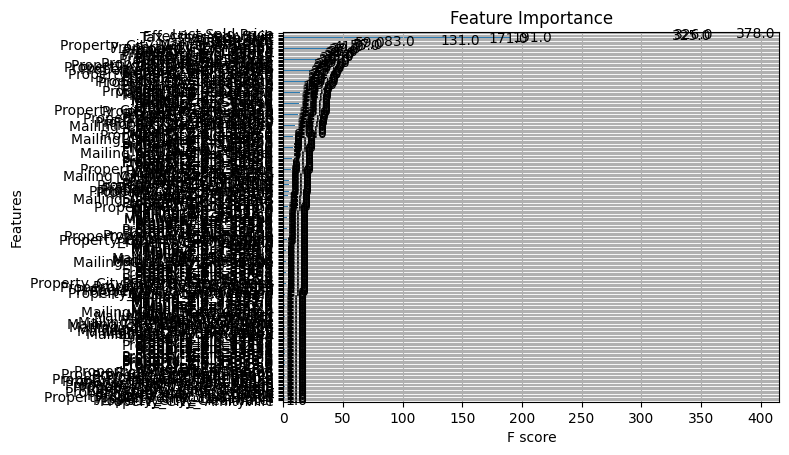

                           Feature  Importance
267                Last Sold Price       378.0
265           Effective Year Built       326.0
266             Tax Assessed Value       325.0
264                  Lot Size Sqft       191.0
263                    Apporx Sqft       171.0
261                        Bedroom       131.0
262                       Bathroom        83.0
211               Mailing_State_FL        59.0
55   Property_City_New Port Richey        57.0
4           Property_City_ Brandon        55.0
97              Property_Zip_33063        41.0
31            Property_City_ Tampa        39.0
72               Property_State_FL        37.0
33          Property_City_ Valrico        36.0
80              Property_Zip_33020        35.0


<ipython-input-42-60a2fa8c3713>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_15_featuresb, palette='viridis')


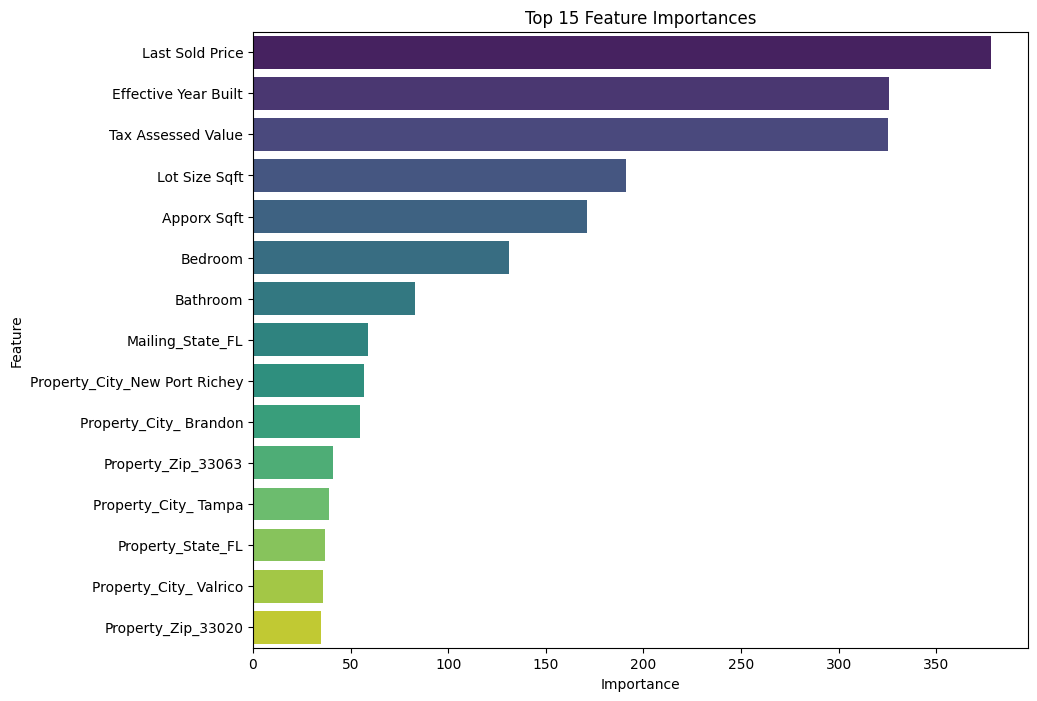

In [42]:
#training model 2. uses hyperparameters to adjust for underfitting

xgb1b = XGBClassifier(
    max_depth=6,              # Increase max_depth
    min_child_weight=1,       # Lower min_child_weight
    gamma=0,                  # Lower gamma
    subsample=0.8,            # Increase subsample
    colsample_bytree=0.8,     # Increase colsample_bytree
    learning_rate=0.05,       # Lower learning_rate
    n_estimators=200          # Increase n_estimators
)

#  Train the Model
model1b = xgb1b.fit(X_train_balanced, y_train_balanced)

#  Evaluate the Model
y_predb = model1b.predict(X_test)

accuracy1b = accuracy_score(y_test, y_predb)
recall1b = recall_score(y_test, y_predb, average='binary')  # Use average='binary' for binary classification
precision1b = precision_score(y_test, y_predb, average='binary')  # Use average='binary' for binary classification
f1b = f1_score(y_test, y_predb)

print("F1 Score:", f1b)
print(f"Test Accuracy: {accuracy1b}")
print(f"Test Recall: {recall1b}")
print(f"Test Precision: {precision1b}")

#

cm = confusion_matrix(y_test, y_predb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=xgb.classes_, yticklabels=xgb.classes_)
plt.title('Confusion Matrix with adjusted hyperparameters for underfitting')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

  # Plot Feature Importances for model 1b

plt.figure(figsize=(10, 8))
plot_importance(model1b, importance_type='weight')
plt.title('Feature Importance')
plt.show()

#  Get Feature Importances as a DataFrame
feature_importancesb = model1b.get_booster().get_score(importance_type='weight')
feature_importances_dfb = pd.DataFrame(feature_importancesb.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Get top 15 features
top_15_featuresb = feature_importances_dfb.head(15)
print(top_15_featuresb)

# Plot top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_15_featuresb, palette='viridis')
plt.title('Top 15 Feature Importances')
plt.show()


F1 Score: 0.27532869296210366
Test Accuracy: 0.9566451254684825
Test Recall: 0.8612903225806452
Test Precision: 0.1638539429272783


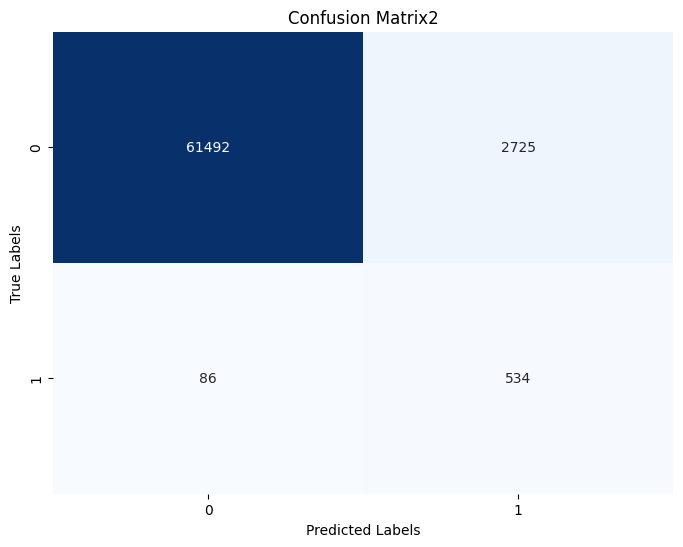

In [43]:
'''


Model3.
xgboost with RE and raw, predicting if will become any sort of lead
and adjusted hyperparameters to avoid overfitting.

xgb3 = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=1.0
)

F1 Score: 0.27532869296210366
Test Accuracy: 0.9566451254684825
Test Recall: 0.8612903225806452
Test Precision: 0.1638539429272783
'''

#  Manually Set Hyperparameters to tune for overfitting
xgb3 = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=1.0
)

#  Train the Model
model3 = xgb3.fit(X_train_balanced, y_train_balanced)

#  Evaluate the Model
y_pred3 = model3.predict(X_test)

accuracy3 = accuracy_score(y_test, y_pred3)
recall3 = recall_score(y_test, y_pred3, average='binary')
precision3 = precision_score(y_test, y_pred3, average='binary')
f13 = f1_score(y_test, y_pred3)

print("F1 Score:", f13)
print(f"Test Accuracy: {accuracy3}")
print(f"Test Recall: {recall3}")
print(f"Test Precision: {precision3}")

#

#confusion matrix
cm2 = confusion_matrix(y_test, y_pred3)
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=model3.classes_, yticklabels=model3.classes_)
plt.title('Confusion Matrix2')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
'''

model2. xgboost with RE and raw, predicting if will become any sort of lead
Takes best hyperparameters and trains on less features.


Predictors:
    b['Tax Assessed Value'],
    b['Last Sold Price'],
    b['Apporx Sqft'],
    b['Effective Year Built']
    b['Lot size square feet]



Target:
b['Lead at all']


F1 Score: 0.2265178328341955
Test Accuracy: 0.9561824267008036
Test Recall: 0.6709677419354839
Test Precision: 0.1362594169669178
'''

In [45]:
#retrain with top feature importances model2
b_features2 = pd.concat([
    b['Tax Assessed Value'],
    b['Last Sold Price'],
    b['Apporx Sqft'],
    b['Effective Year Built'],
    b['Lot Size Sqft']
    ], axis=1)

In [46]:
#train test split and duplicate rare events

X2 = b_features2
y2 = b['Lead at all']

# Split Data into Training and Test Sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.5, random_state=42, stratify=y2)

# Identify and Separate Minority and Majority Classes
minority_class2 = y_train2.value_counts().idxmin()
majority_class2 = y_train2.value_counts().idxmax()

X_train_minority2 = X_train2[y_train2 == minority_class2]
y_train_minority2 = y_train2[y_train2 == minority_class2]
X_train_majority2 = X_train2[y_train2 == majority_class2]
y_train_majority2 = y_train2[y_train2 == majority_class2]

#  Duplicate Rarer Events to Balance the Dataset
n_minority2 = len(X_train_minority2)
n_majority2 = len(X_train_majority2)
n_duplicate2 = n_majority2 - n_minority2

X_train_minority_upsampled2 = X_train_minority2.sample(n=n_duplicate, replace=True, random_state=42)
y_train_minority_upsampled2 = y_train_minority2.sample(n=n_duplicate, replace=True, random_state=42)

X_train_balanced2 = pd.concat([X_train_majority2, X_train_minority2, X_train_minority_upsampled2])
y_train_balanced2 = pd.concat([y_train_majority2, y_train_minority2, y_train_minority_upsampled2])

F1 Score: 0.2265178328341955
Test Accuracy: 0.9561824267008036
Test Recall: 0.6709677419354839
Test Precision: 0.1362594169669178


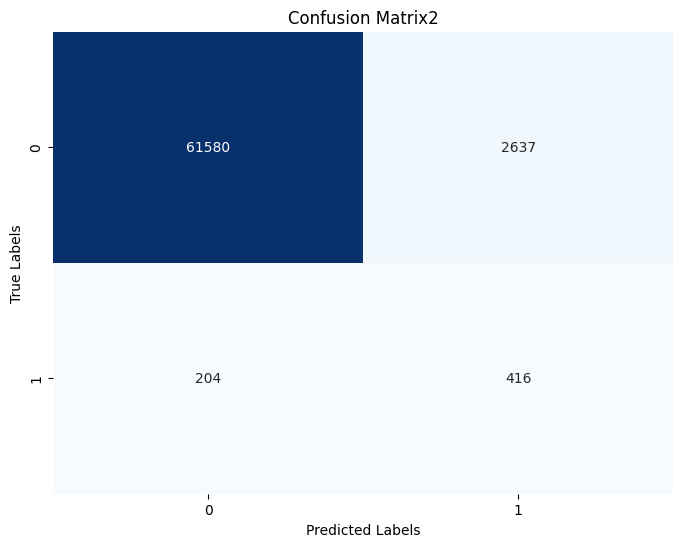

In [48]:
#training the model

# Manually Set Hyperparameters
xgb2 = XGBClassifier(
    max_depth=6,              # Increase max_depth
    min_child_weight=1,       # Lower min_child_weight
    gamma=0,                  # Lower gamma
    subsample=0.8,            # Increase subsample
    colsample_bytree=0.8,     # Increase colsample_bytree
    learning_rate=0.05,       # Lower learning_rate
    n_estimators=200          # Increase n_estimators
)

#  Train the Model
model2 = xgb2.fit(X_train_balanced2, y_train_balanced2)

#  Evaluate the Model
y_pred2 = model2.predict(X_test2)

accuracy2 = accuracy_score(y_test2, y_pred2)
recall2 = recall_score(y_test2, y_pred2, average='binary')  # Use average='binary' for binary classification
precision2 = precision_score(y_test2, y_pred2, average='binary')  # Use average='binary' for binary classification
f12 = f1_score(y_test2, y_pred2)

print("F1 Score:", f12)
print(f"Test Accuracy: {accuracy2}")
print(f"Test Recall: {recall2}")
print(f"Test Precision: {precision2}")

#

#confusion matrix
cm2 = confusion_matrix(y_test2, y_pred2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=model2.classes_, yticklabels=model2.classes_)
plt.title('Confusion Matrix2')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()